In [ ]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os


GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/Coursework/' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['CW_Dataset-2.zip', 'Untitled0.ipynb', 'EmotionRecognition.py', '__pycache__']


In [ ]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset-2.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CW_Dataset-2.zip

# Delete zipped version from Colab (not from Drive)
!rm CW_Dataset-2.zip

In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 6.9MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 163kB 52.7MB/s 
     |████████████████████████████████| 112kB 45.7MB/s 
     |████████████████████████████████| 143kB 52.9MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 81kB 8.8MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=1c5fd34f7a161d7349ad37124c0ae7e5d304ee63cac2ae60213b3fa35202f9d7
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import cv2
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Lambda
import time
import pandas as pd
import copy
from PIL import Image
from skimage import io
from skimage.feature import hog
from skimage import data, exposure
from sklearn.model_selection import train_test_split
import optuna
from optuna.trial import TrialState

%matplotlib inline

In [ ]:
class CustomHOGSDataset(Dataset):

    def __init__(self, annotations_df, img_dir, transform=None, target_transform=None):
        self.img_labels = annotations_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = io.imread(img_path)
        h = image.copy()
        #image = Image.open(img_path)
        #image = torch.from_numpy(image)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        inp = image.numpy().transpose((1, 2, 0))
        HOG_des = hog(inp, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1),block_norm = "L1", multichannel=True)
      
        sample = {"image": image, "label": label, "HOG_des": HOG_des}
        return image, label, HOG_des #Creating Custom DataSet

In [ ]:
class MLP(nn.Module):
    def __init__( #Creating MLP 
            self,
            hidden_num = 40,
            dropout = 0.1,
            nonlin = torch.nn.Sigmoid()

    
    ):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1152,hidden_num)
        self.fc2 = nn.Linear(hidden_num,8)
        self.non_lin = nonlin
        self.dropout = dropout
        
    def forward(self, x):
        hidden = self.fc1(x)
        hidden = self.non_lin(hidden)
        output = self.fc2(hidden)
        return output
#OPTIMAL PARAMETERS 

In [ ]:
data_dir = "CW_Dataset-2"
l = os.path.join(data_dir, "labels", "list_label_train.txt")
l_test = os.path.join(data_dir, "labels", "list_label_test.txt")
d = os.path.join(data_dir, "train")
d_test = os.path.join(data_dir, "test")

In [ ]:
lab = pd.read_csv(l, delimiter= ' ',header=None)
lab = lab.rename(columns={0: "name", 1: "lbl"})
lab['name'] = lab['name'].str[:-4] + "_aligned" + ".jpg"
lab['lbl'] = lab['lbl']-1

train_lab, val_lab = train_test_split(lab, test_size=0.2) #Split the dataset to get a set for validation

test_lab = pd.read_csv(l_test, delimiter= ' ',header=None)
test_lab = test_lab.rename(columns={0: "name", 1: "lbl"})
test_lab['name'] = test_lab['name'].str[:-4] + "_aligned" + ".jpg"
test_lab['lbl'] = test_lab['lbl'] - 1

In [ ]:
data_means = [0.485, 0.456, 0.406]
data_stds = [0.229, 0.224, 0.225]

training_data = CustomHOGSDataset(train_lab, d, transform=transforms.Compose([transforms.ToPILImage(),# Performing Augmentations
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.RandomRotation(10),
        transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)]))

validation_data = CustomHOGSDataset(val_lab, d, transform=transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)]))

test_data = CustomHOGSDataset(test_lab, d_test, transform=transforms.Compose([transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Normalize(data_means, data_stds)]))

In [ ]:
ds_train = DataLoader(training_data, batch_size =64, shuffle=True)
ds_val = DataLoader(validation_data, batch_size =64, shuffle=True)
ds_test = DataLoader(test_data, batch_size =1, shuffle=True)

In [ ]:
training_dataset_sizes = len(training_data.img_labels)
training_dataset_sizes

validation_dataset_sizes = len(validation_data.img_labels)
validation_dataset_sizes

test_dataset_sizes = len(test_data.img_labels)
test_dataset_sizes

NameError: ignored

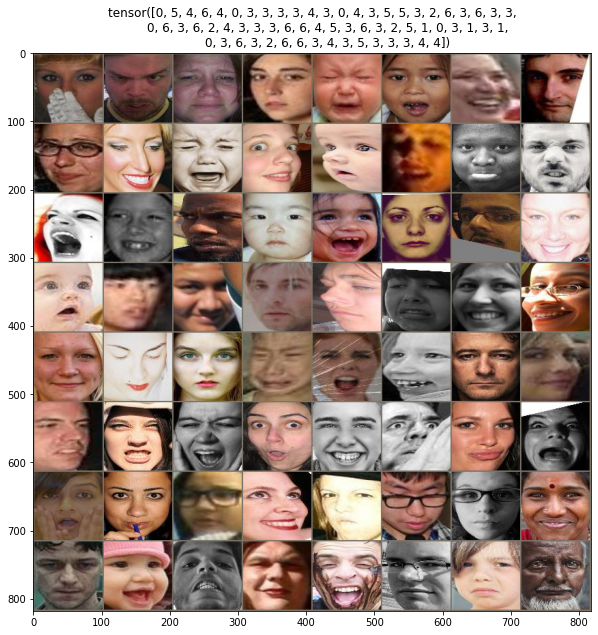

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.asarray(data_stds) * inp + np.asarray(data_means)
    inp = np.clip(inp, 0, 1)       # Clip to intensity outliers to [0, 1] range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)


# Get a batch of training data
first_inputs, first_classes, first_hogs = next(iter(ds_val))
#first_inputs, first_classes = sample['image'], sample['label']
# Make a grid from batch
out = torchvision.utils.make_grid(first_inputs)

plt.figure(figsize=(10, 15))
imshow(out, title=first_classes)
plt.show()

In [ ]:
### FOLLOWED THE FOLLOWING TUTORIAL https://broutonlab.com/blog/efficient-hyperparameter-optimization-with-optuna-framework ###

def train_model(trial, model, criterion, optimizer, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        
       # print(f"Epoch {epoch}/{num_epochs - 1}")
       # print('----------------')

        # Each epoch has a training and validation phase
        
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

            # Iterate over data
        for inputs, labels, desc in ds_train:
       
                # move data to GPU
                desc = desc.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(True):
           
                    outputs = model(desc.float())
                    _, preds = torch.max(outputs, 1)
      
                    
                    loss = criterion(outputs, labels)
             
                    # backward + optimize only if in training phase

                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * desc.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # update learning rate with scheduler



        epoch_loss = running_loss / training_dataset_sizes
        epoch_acc = running_corrects.double() / training_dataset_sizes

        #print(f"train loss: {epoch_loss:.4f} train acc: {epoch_acc:.4f}")
      
        
        model.eval()  # Set model to evaluation mode
        running_loss = 0.0
        running_corrects = 0

        for inputs_val, labels_val, desc_val in ds_val:
                # move data to GPU
                desc_val = desc_val.to(device)
                labels_val = labels_val.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(False):
                    outputs_val = model(desc_val.float())
               
                    _, preds_val = torch.max(outputs_val, 1)
                    loss_val = criterion(outputs_val, labels_val)

                # statistics
                running_loss += loss_val.item() * desc_val.size(0)
                running_corrects += torch.sum(preds_val == labels_val.data)


        epoch_loss = running_loss / validation_dataset_sizes
        epoch_acc = running_corrects.double() / validation_dataset_sizes


            # deep copy the model with best accuracy on validation set
        if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


        trial.report(epoch_acc, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    time_elapsed = time.time() - since


    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [ ]:
def objective(trial):
    
    # Hyperparameters
    params = {
       # "model_name": trial.suggest_categorical('model_name',["resnet18", "alexnet", "vgg16"]),
        "lr": trial.suggest_loguniform('lr', 1e-5, 1e-2),
        "optimizer_name": trial.suggest_categorical('optimizer_name',["SGD", "Adam"])
    }
    
    # Get pretrained model
    model = MLP()

    model = model.to(device)
    
    # Define criterion
    criterion = nn.CrossEntropyLoss()
    
    # optimizer params
    optimizer = getattr(
        torch.optim, params["optimizer_name"]
    )(model.parameters(), lr=params["lr"])
    
    # Train model
    best_model, best_acc = train_model(trial, model, criterion, optimizer, num_epochs=20)

    return best_acc

In [ ]:
sampler = optuna.samplers.TPESampler()    
study = optuna.create_study(
    sampler=sampler,
    pruner=optuna.pruners.HyperbandPruner(
    ),
    direction='maximize')
study.optimize(func=objective, n_trials=20)

[I 2021-04-30 01:50:53,872] A new study created in memory with name: no-name-f36db6a8-a509-476b-9868-c49055014a32
[I 2021-04-30 02:12:45,225] Trial 0 finished with value: 0.485132382892057 and parameters: {'lr': 0.00011997588167134204, 'optimizer_name': 'Adam'}. Best is trial 0 with value: 0.485132382892057.
[I 2021-04-30 02:34:37,793] Trial 1 finished with value: 0.664765784114053 and parameters: {'lr': 0.0038958622256026858, 'optimizer_name': 'Adam'}. Best is trial 1 with value: 0.664765784114053.
[I 2021-04-30 02:45:33,663] Trial 2 pruned. 
[I 2021-04-30 02:56:28,067] Trial 3 pruned. 
[I 2021-04-30 03:18:30,247] Trial 4 finished with value: 0.3784114052953157 and parameters: {'lr': 0.0007753482096239212, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.664765784114053.
[I 2021-04-30 03:40:16,872] Trial 5 finished with value: 0.6321792260692465 and parameters: {'lr': 0.009554121144757144, 'optimizer_name': 'Adam'}. Best is trial 1 with value: 0.664765784114053.
[I 2021-04-30 0